In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

In [2]:
annonimized = pd.read_csv("annonimized.csv")  
ck_public = pd.read_csv("ck-public.csv")  
ck_public

,hash,CK
0,00b6dd4fc7eb817e03708c532016ef30ce564a61,5.5
1,00bef8afee8f3c595d535c9c03c490cac1a4f021,6.5
2,01122b3ef7e59b84189e65985305f575d6bdf83c,4.5
3,013de369c439ab0ead8aa7da64423aa395a8be39,5.0
4,014c59c6433fd764a0b08de6ffeb757eaf60aa73,4.0
...,...,...
756,840d07858c03f80f4695056e2cc7d0c474b83a25,5.5
757,844f5db2e7e31ae51eba025480679ed7e4708ac6,6.0
758,845acd04a77b3d1b623f255d9f9f8eae90892dab,6.0
759,8460eaaf887a6289fb156f7562fb739ba8e9629e,7.0


In [3]:
column_mapping = {
    "concat('it001',`assignment_id`)": "assignment_id",
    "concat('it001',`problem_id`)": "problem_id",
    "concat('it001', username)": "username",
    "is_final": "is_final",
    "status": "status",
    "pre_score": "pre_score",
    "coefficient": "coefficient",
    "concat('it001',`language_id`)": "language_id",
    "created_at": "created_at",
    "updated_at": "updated_at",
    "judgement": "judgement"
}

column_mapping_th = {
    "hash": "username",
    "CK": "CK"
}

annonimized.rename(columns=column_mapping, inplace=True)

ck_public.rename(columns=column_mapping_th, inplace=True)

In [4]:
problem_count_per_assignment = annonimized.groupby('assignment_id')['problem_id'].count().reset_index()
problem_count_per_assignment.rename(columns={'problem_id': 'total_problem_count'}, inplace=True)

assignment_count_per_user = annonimized.groupby('username')['assignment_id'].count().reset_index()
assignment_count_per_user.rename(columns={'assignment_id': 'total_assignment_count'}, inplace=True)

annonimized = annonimized.merge(problem_count_per_assignment, on='assignment_id', how='left')
annonimized = annonimized.merge(assignment_count_per_user, on='username', how='left')

status_mapping = {
    'SCORE': 0,
    'Compilation Error': 1,
    'Syntax Error': 2,
    'pending': 3
}

if 'status' in annonimized.columns:
    annonimized['status_normalized'] = annonimized['status'].map(status_mapping)

In [5]:
grouped_data = annonimized.groupby('username').agg({
    'assignment_id': lambda x: '|'.join(map(str, x.unique())),  
    'problem_id': lambda x: '|'.join(map(str, x.unique())),     
    'pre_score': 'mean',  
    'coefficient' : 'mean' , 
    'status_normalized' : 'sum',
    'judgement': lambda x: '|'.join(map(str, x.unique())),  
    'total_problem_count': 'first',  
    'total_assignment_count': 'first'  
}).reset_index()

In [6]:
grouped_data = grouped_data.merge(ck_public[['username', 'CK']], on='username', how='left')

In [7]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

def encode_column(col):
    return col.apply(lambda x: len(set(x.split('|'))))

grouped_data.loc[:, 'assignment_id'] = encode_column(grouped_data['assignment_id'])
grouped_data.loc[:, 'problem_id'] = encode_column(grouped_data['problem_id'])
grouped_data.loc[:, 'judgement'] = encode_column(grouped_data['judgement'])

In [8]:
grouped_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1489 entries, 0 to 1488
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   username                1489 non-null   object 
 1   assignment_id           1489 non-null   object 
 2   problem_id              1489 non-null   object 
 3   pre_score               1489 non-null   float64
 4   coefficient             1489 non-null   float64
 5   status_normalized       1489 non-null   int64  
 6   judgement               1489 non-null   object 
 7   total_problem_count     1489 non-null   int64  
 8   total_assignment_count  1489 non-null   int64  
 9   CK                      755 non-null    float64
dtypes: float64(3), int64(3), object(4)
memory usage: 116.5+ KB


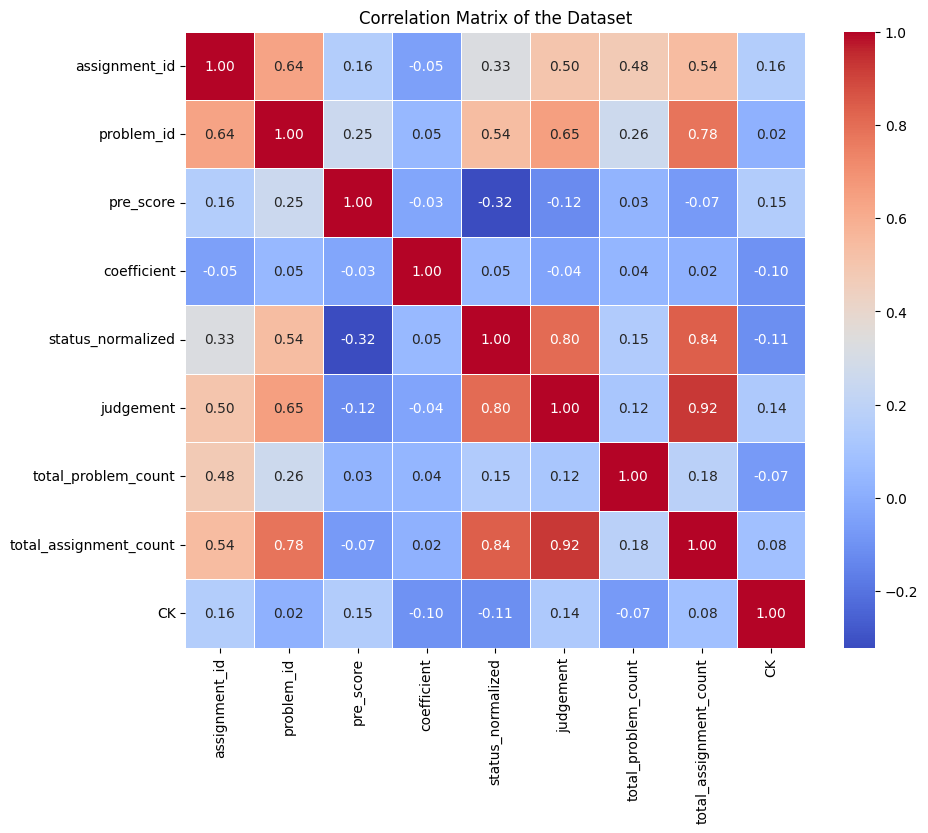

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.cluster import KMeans

train_data_new = grouped_data.copy()

train_data_new['CK'] = pd.to_numeric(train_data_new['CK'], errors='coerce')

correlation_matrix = train_data_new.drop(columns="username").corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix of the Dataset')
plt.show()

In [10]:
grouped_data.columns

Index(['username', 'assignment_id', 'problem_id', 'pre_score', 'coefficient',
       'status_normalized', 'judgement', 'total_problem_count',
       'total_assignment_count', 'CK'],
      dtype='object')

In [11]:
train_data = grouped_data.dropna(subset=['CK']).copy()  

features = ['assignment_id', 'problem_id', 'pre_score', 'judgement', 'total_assignment_count','total_problem_count', "status_normalized"]

X = train_data[features]
y = train_data['CK']

print(y.unique())  
y = y.replace({'\xa0': 0, '': 0}, regex=True) 
y = y.astype(float)  

[ 5.5  6.5  4.5  5.   4.   8.   7.   6.   3.5  9.   7.5  8.5  3.  10.
  0.   9.5  2.   1.   2.5  0.5  1.5]


In [12]:
from sklearn.ensemble import GradientBoostingRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split, KFold

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

model = CatBoostRegressor(verbose=0)

model.fit(X_train, y_train)

In [13]:
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mse = ((y_test - y_pred) ** 2).mean()

print(f"Đánh giá hiệu năng mô hình:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R²): {r2:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")

Đánh giá hiệu năng mô hình:
Mean Absolute Error (MAE): 1.5457
R-squared (R²): 0.2847
Mean Squared Error (MSE): 3.2588


In [14]:
from sklearn.ensemble import GradientBoostingRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split, KFold

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

model = CatBoostRegressor(verbose=0)

model.fit(X, y)

In [15]:
data_to_predict = grouped_data[grouped_data['CK'].isna()]

X_to_predict = data_to_predict[features]
data_to_predict.loc[:, 'CK'] = model.predict(X_to_predict)

In [16]:
output = data_to_predict[['username', 'CK']]

output['CK'] = output['CK'].astype(float).round(2)

output

C:\Users\Admin\AppData\Local\Temp\ipykernel_3360\925792871.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  output['CK'] = output['CK'].astype(float).round(2)


,username,CK
3,0134f9f410c65ad0e8c2254a7e9288670e02a183,4.37
20,035f97702f2c01d26ab1fae8f39ea2f98a0caa3c,4.72
40,06024da8147b5cf6105beb4c403f67cf1ff0aea1,7.11
68,0aaebc88f6106684d6993c156104c1ef36cf94e0,5.16
80,0bf111a9caedf02804f6991792490e63bc21058a,6.92
...,...,...
1484,feb8a2859a011c59efd22ed419cb69288fe03627,7.13
1485,fef4a3263ed9a8ab14d457694bb8fd86ccd98312,5.44
1486,ff12d6e2ab80696ed8e22fbe5497e96c68d29076,5.45
1487,ff3fa2ec64294f37ae968159f810ebeda7966c51,4.67


In [17]:
output.to_csv("predicted_CK_for_new_users.csv", index=False, header=False)

print("Kết quả dự đoán đã được lưu vào predicted_th_for_new_users.csv")

Kết quả dự đoán đã được lưu vào predicted_th_for_new_users.csv
